# Tutorial: Accelerating pygpc by using different computing backends

This tutorial shows how to accelerate pygpc by choosing different computing backends. At the moment, the following backends are available:
1. Implementation in **Python**: pygpc names this backend **python**   
2. Implementation in **C++**: pygpc names this backend **cpu**
3. Implementation in **C++** and **OpenMP**: pygpc names this backend **omp**
4. Implementation in **CUDA-C++**: pygpc names this backend **cuda**, an Nvidia GPU is required

# Let's get started

## Setting up benchmark parameters
We define the number of samples, the dimensionality of the parameter space and the maximum number of basis functions. This will determine the size of the gPC matrix and therefore the compute time.

In [8]:
n_dim = 4
n_samples = 100000
n_basis_order = 8
n_qoi = 100
n_iterations = 3

## Setting up problem and grid

In [2]:
import pygpc
import numpy as np
from collections import OrderedDict

# define model
model = pygpc.testfunctions.DiscontinuousRidgeManufactureDecay()

# define parameters
parameters = OrderedDict()
for i_dim in range(n_dim):
    parameters["x"+str(i_dim)] = pygpc.Beta(pdf_shape=[1, 1], pdf_limits=[1.2, 2])

# define problem
problem = pygpc.Problem(model, parameters)

# define grid
options = dict()
grid = pygpc.Random(parameters_random=problem.parameters_random,
                                      n_grid=n_samples,
                                      options={"n_grid": n_samples, "seed": 1})

# define gPC
gpc = pygpc.Reg(problem=problem,
                order=[n_basis_order] * n_dim,
                order_max=n_basis_order,
                order_max_norm=1,
                interaction_order=n_dim,
                interaction_order_current=n_dim,
                options=options)
gpc.grid = grid

# get number of basis functions
n_basis = pygpc.get_num_coeffs_sparse([n_basis_order] * n_dim, n_basis_order, n_dim, n_dim, n_dim, 1)

# create coefficient matrix
coeffs = np.ones((len(gpc.basis.b), n_qoi))

## Performance comparison between the backends
Per default the **omp**-backend is set. Let's try them all and see how the performance changes.

In [4]:
import time
backends = ["python", "cpu", "omp", "cuda"]
labels = ["Python", "C++", "C++ OpenMP", "CUDA"]

backends = ["python", "cpu", "omp"]
labels = ["Python", "C++", "C++ OpenMP"]

time_create_gpc_matrix = OrderedDict()
time_get_approximation = OrderedDict()

for b in backends:
    time_create_gpc_matrix[b] = []
    time_get_approximation[b] = []

# warmup to wake gpu up from idle
if "cuda" in backends:
for _ in range(10):
    gpc.backend = "cuda"
    gpc.create_gpc_matrix(b=gpc.basis.b, x=gpc.grid.coords_norm)
    
# benchmark
for _ in range(n_iterations):
    # python backend
    for b in backends:
        gpc.backend = b
    
        # benchmark create_gpc_matrix
        start = time.time()
        gpc.create_gpc_matrix(b=gpc.basis.b, x=gpc.grid.coords_norm)
        stop = time.time()
        time_create_gpc_matrix[b].append(stop-start)
    
        # benchmark get_approximation
        start = time.time()
        gpc.get_approximation(coeffs, x=gpc.grid.coords_norm)
        stop = time.time()
        time_get_approximation[b].append(stop-start)

## Results

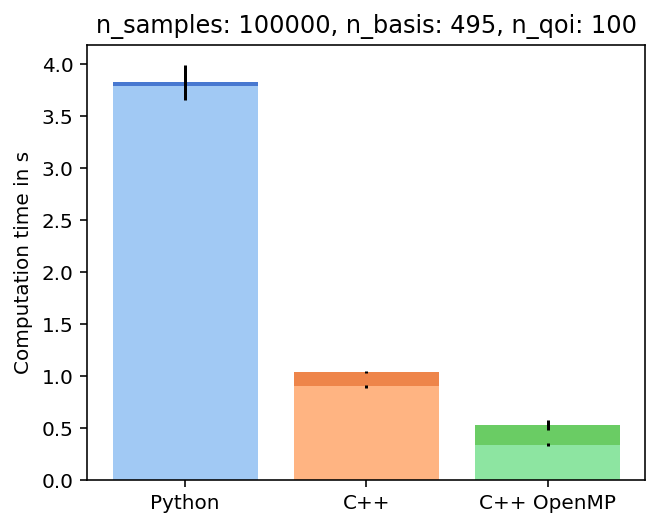

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
%config InlineBackend.figure_format = 'retina'

# plot results
plt.figure(figsize=[5, 4])
for ind, b in enumerate(backends):   
    plt.bar(ind, np.mean(time_get_approximation[b]), yerr=np.std(time_get_approximation[b]), color = sns.color_palette("muted", len(backends))[ind])
    plt.bar(ind, np.mean(time_create_gpc_matrix[b]), yerr=np.std(time_create_gpc_matrix[b]), color = sns.color_palette("pastel", len(backends))[ind])
        
plt.ylabel("Computation time in s")
plt.xticks(range(len(labels)), labels)
plt.title("n_samples: {}, n_basis: {}, n_qoi: {}".format(n_samples, n_basis, n_qoi))
plt.show()